In [3]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle

import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [4]:
with open("mldf_1000_full_dec.p", "rb") as input_file:
    mldf = pickle.load(input_file)
cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

In [5]:
new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
            print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)

z[ 2279 ]:  16083.040852156164 z[ 2280 ]:  96.92866711757479 
z[ 5463 ]:  16159.208375513363 z[ 5464 ]:  477.0236262455019 
z[ 8382 ]:  16082.29167830329 z[ 8383 ]:  199.751681970277 
z[ 11351 ]:  16145.488789950328 z[ 11352 ]:  325.0778025978937 
z[ 14204 ]:  16230.737128997915 z[ 14205 ]:  1356.670371207836 
z[ 16997 ]:  16112.14588623644 z[ 16998 ]:  369.4320353846112 
z[ 20009 ]:  16131.569027888616 z[ 20010 ]:  -100.20981400075614 
z[ 22987 ]:  16247.480892504302 z[ 22988 ]:  11.494529721060713 
z[ 26091 ]:  16268.596474606169 z[ 26092 ]:  303.70289869544376 
z[ 29214 ]:  16056.172165014732 z[ 29215 ]:  685.8155420702224 
z[ 32046 ]:  16109.777082805187 z[ 32047 ]:  772.5859672801632 
z[ 35235 ]:  16108.30829550608 z[ 35236 ]:  56.64580879103067 
z[ 37801 ]:  16230.48808505658 z[ 37802 ]:  1078.7986295880735 
z[ 41022 ]:  16085.594675966413 z[ 41023 ]:  28.03652601938242 
z[ 44491 ]:  16572.906932956797 z[ 44492 ]:  331.3817509514718 
z[ 47694 ]:  16117.2962309781 z[ 47695 ]:  214

In [19]:
with open('mldf_1000_full_dec.p', "rb") as input_file:
    mldf = pickle.load(input_file)
for i in ['mldf_1000_full_mar.p', 'mldf_1000_full_sep.p', 'mldf_1000_full_jun.p']:
    with open(i, "rb") as input_file:
        mldf = mldf.append(pickle.load(input_file))

mldf = mldf[mldf < 1000000]
mldf = mldf[mldf > -1000000]
mldf = mldf.dropna()
for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

In [20]:
test

,temperature,pressure,u,v,latd,lond,lat,lon,calc_latd,calc_lond,z,u_shear,v_shear
1922911,228.61,20390.0,-14.080676,0.737937,0.21351,-0.04650,47.93,-124.56,0.305042,-0.033391,11556.091197,-0.099863,0.005234
1922912,228.60,20380.0,-14.080676,0.737937,0.21362,-0.04654,47.93,-124.56,0.305167,-0.033395,11559.373785,0.000000,0.000000
1922913,228.62,20360.0,-14.180539,0.743171,0.21378,-0.04655,47.93,-124.56,0.305416,-0.033404,11565.943941,-0.099863,0.005234
1922914,228.63,20350.0,-14.180539,0.743171,0.21394,-0.04656,47.93,-124.56,0.305541,-0.033408,11569.231655,0.000000,0.000000
1922915,228.64,20340.0,-14.180539,0.743171,0.21406,-0.04659,47.93,-124.56,0.305666,-0.033413,11572.521129,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9354967,214.61,10030.0,-1.432621,4.685893,0.16882,0.30456,41.66,-69.96,0.223993,0.231779,16543.085992,-0.164408,-0.047143
9354968,214.65,10020.0,-1.514183,4.660177,0.16885,0.30441,41.66,-69.96,0.224015,0.231726,16549.352816,-0.081562,-0.025716
9354969,214.66,10010.0,-1.627841,4.727593,0.16887,0.30435,41.66,-69.96,0.224038,0.231673,16555.626628,-0.113657,0.067416
9354970,214.65,10000.0,-1.675899,4.604494,0.16889,0.30430,41.66,-69.96,0.224063,0.231620,16561.906710,-0.048058,-0.123099


In [21]:
new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
            print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)

z[ 967 ]:  16292.025287982811 z[ 968 ]:  204.6397117941135 
z[ 4067 ]:  16532.06990515116 z[ 4068 ]:  -34.3304806027192 
z[ 7145 ]:  16572.873556679166 z[ 7146 ]:  249.32041134535888 
z[ 10312 ]:  16477.869258945047 z[ 10313 ]:  859.6144597891184 
z[ 13537 ]:  16684.766280561824 z[ 13538 ]:  950.941674931059 
z[ 16811 ]:  16779.5221424782 z[ 16812 ]:  400.0343408816839 
z[ 20030 ]:  16312.816564260496 z[ 20031 ]:  1615.2424591675945 
z[ 23193 ]:  16449.74523280415 z[ 23194 ]:  238.56212191724532 
z[ 26739 ]:  16744.245356610027 z[ 26740 ]:  -18.10573808625712 
z[ 30141 ]:  16403.254596518495 z[ 30142 ]:  1255.5918253177397 
z[ 33254 ]:  16593.86555719549 z[ 33255 ]:  59.480765243382436 
z[ 36627 ]:  16734.876480359468 z[ 36628 ]:  122.2866752854633 
z[ 39953 ]:  16748.662502106803 z[ 39954 ]:  -1.3004673136428022 
z[ 43118 ]:  16577.858550358138 z[ 43119 ]:  50.12539802232339 
z[ 46737 ]:  16615.893493179654 z[ 46738 ]:  792.8293688266035 
z[ 49763 ]:  16431.04575283873 z[ 49764 ]:  10

---
---

In [6]:
train = train.dropna()

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

# try:
with open('model_dt_full_4seasons_reduced.p', "rb") as input_file:
    model_dt = pickle.load(input_file)
print('loading successful')

# except:
#     model_dt = DecisionTreeRegressor()
#     model_dt.fit(train[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']], train[['latd', 'lond']])

#     #     model_dt_wo_coords = DecisionTreeRegressor()
#     #     model_dt_wo_coords.fit(train[['temperature', 'pressure', 'u', 'v', 'z','calc_latd', 'calc_lond']], train[['latd', 'lond']])


#     with open("model_dt_full_dec.p.p", "wb") as output_file:
#         pickle.dump(model_dt, output_file)
#     #     with open("model_dt_wo_coords_1000.p", "wb") as output_file:
#     #         pickle.dump(model_dt_wo_coords, output_file)

loading successful


In [9]:
test

,temperature,pressure,u,v,latd,lond,lat,lon,calc_latd,calc_lond,z,u_shear,v_shear
7554698,264.93,57350.0,-6.807734,-2.344091,0.00658,0.01553,35.23,-111.82,0.009427,0.014913,4445.985502,-0.135916,0.084252
7554699,264.89,57310.0,-6.859756,-2.496747,0.00662,0.01559,35.23,-111.82,0.009508,0.014936,4451.395759,-0.052022,-0.152656
7554700,264.84,57270.0,-6.908495,-2.651923,0.00665,0.01568,35.23,-111.82,0.009591,0.014961,4456.808873,-0.048739,-0.155176
7554701,264.80,57220.0,-7.047695,-2.565151,0.00672,0.01578,35.23,-111.82,0.009695,0.014993,4463.579434,-0.139199,0.086772
7554702,264.75,57180.0,-7.095211,-2.723596,0.00681,0.01585,35.23,-111.82,0.009779,0.015019,4468.999223,-0.047517,-0.158445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9443368,221.75,1100.0,1.363997,1.462707,0.04451,1.37320,28.39,129.55,0.043435,1.493422,30022.589781,0.102129,-0.339427
9443369,222.24,1090.0,1.118386,1.658075,0.04459,1.37307,28.39,129.55,0.043287,1.493255,30081.933304,-0.245611,0.195368
9443370,222.71,1080.0,1.338261,1.486290,0.04471,1.37311,28.39,129.55,0.043138,1.493085,30141.953278,0.219875,-0.171785
9443371,223.07,1070.0,1.638304,1.147153,0.04509,1.37273,28.39,129.55,0.042956,1.492942,30202.644595,0.300043,-0.339137


Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0007251089570353981
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0009298761068553099
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.000369578784702072
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.00040141326250432203
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0007251089570353981
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0009298761068553099
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.002599630386980681
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.002499952308014801
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.000958267732984872
Longitude Displacement data set 2 - plev:  85000  RMSE:  0.001088050049542473
Latitude Displacement data set 1 - plev:  85000  RMS:  0.002599630386980681
Longitude Displacement data set 1 - plev:  85000  RMS:  0.002499952308014801
Latitude Displacement data set 1 - plev:  70000  RMSE:  0.0067486214

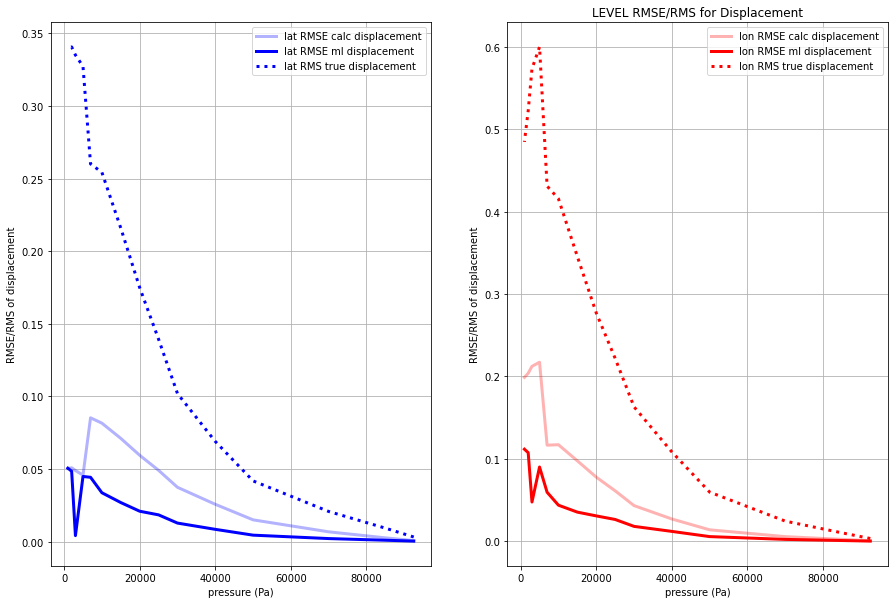

In [26]:
stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_lon_1={}
rmse_sum_lat_1={}
rmse_sum_lon_2={}
rmse_sum_lat_2={}

rms_sum_lon_0={}
rms_sum_lat_0={}

for i in stdplevs:
    rmse_sum_lon_1[i] = []
    rmse_sum_lat_1[i] = []
    rmse_sum_lon_2[i] = []
    rmse_sum_lat_2[i] = []
    rms_sum_lon_0[i] = []
    rms_sum_lat_0[i] = []
    
for i in range(len(testidx)):
    if i != 0:
        testdata = test[testidx[i-1]:testidx[i]]
        mlout = model_dt.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']])
        mlout_lat, mlout_lon = mlout.transpose()

        for i in range(len(stdplevs)):
            if i > 0:
                b = np.array(testdata.latd)
                c = np.array(testdata.lond)
                b[testdata.pressure < stdplevs[i]] = np.nan
                b[testdata.pressure >= stdplevs[i-1]] = np.nan
                c[testdata.pressure < stdplevs[i]] = np.nan
                c[testdata.pressure >= stdplevs[i-1]] = np.nan
                rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                a = np.array(testdata.calc_lond)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                a = np.array(testdata.calc_latd)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                a = np.array(mlout_lon)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
        #                         
                a = np.array(mlout_lat)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

rmse_lat_1 = []
rmse_lon_1 = []
rmse_lat_2 = []
rmse_lon_2 = []

rms_lat_0 = []
rms_lon_0 = []
for i in range(len(stdplevs)):
    if i > 0:
        rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
        rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
        rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
        print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
        rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
        print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])

        rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
        rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
print('')
print('ascents: ', len(testidx))
fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE calc displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE ml displacement')
ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS true displacement')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
ax1[0].set_xlabel('pressure (Pa)')
ax1[0].set_ylabel('RMSE/RMS of displacement')
ax1[0].legend()
ax1[0].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE calc displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE ml displacement')
ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS true displacement')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
ax1[1].set_xlabel('pressure (Pa)')
ax1[1].set_ylabel('RMSE/RMS of displacement')
ax1[1].legend()
ax1[1].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
maplt.show()
maplt.close()

In [24]:
np.sqrt(np.nanmean((np.array(rms_sum_lon_0[92500])**2)))

0.1892271863375229

In [25]:
rms_sum_lon_0[92500]

[0.36969090322580644,
 0.012747931825630941,
 0.38807495737290815,
 -0.02157610542635659,
 0.09285930360415394,
 0.22544539919229578,
 0.13987845716092318,
 -0.05568772701635646,
 0.4796786863905325,
 -0.055783363315130105,
 -0.04360886972040452,
 -0.12672186410102226,
 0.24706692993630575,
 0.044097385639035216,
 0.010695350297422341,
 -0.11418790731995278,
 0.4156259595959596,
 0.12877082384823849,
 0.09613109004739337,
 0.10601029335912317,
 0.010253835347007592,
 0.4330962631411278,
 -0.07020282393669634,
 0.10561726740947074,
 0.01638312567421791,
 0.11516752684049081,
 0.3170716768535743,
 0.3426900870147256,
 0.3177588447825053,
 0.18014207205139973,
 0.40366785392869514,
 0.17068573066962633,
 0.23819968335035752,
 0.09644388303298196,
 0.08706532664941787,
 0.235835730958231,
 0.13070394541778976,
 0.19724073965461064,
 0.13423299207606976,
 -0.07084388905281794,
 0.2646989326923077,
 -0.07008899355630561,
 0.32223076160990716,
 0.2515055126254944,
 0.5966977426900585,
 0.1090

# smoothened data

Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0009784031707956884
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0009929904628466057
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.003313068551845505
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.00471929828269951
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0009784031707956884
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0009929904628466057
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.0037622048343390366
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.0025975608419014154
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.0023660328935388923
Longitude Displacement data set 2 - plev:  85000  RMSE:  0.003395986019148666
Latitude Displacement data set 1 - plev:  85000  RMS:  0.0037622048343390366
Longitude Displacement data set 1 - plev:  85000  RMS:  0.0025975608419014154
Latitude Displacement data set 1 - plev:  70000  RMSE:  0.00905610

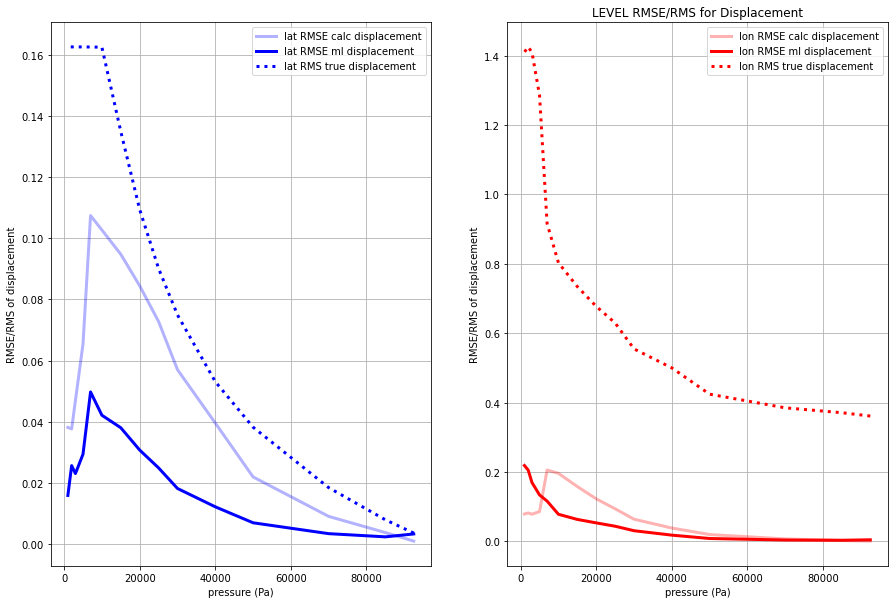

In [18]:
from scipy.signal import savgol_filter

stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_lon_1={}
rmse_sum_lat_1={}
rmse_sum_lon_2={}
rmse_sum_lat_2={}

rms_sum_lon_0={}
rms_sum_lat_0={}

for i in stdplevs:
    rmse_sum_lon_1[i] = []
    rmse_sum_lat_1[i] = []
    rmse_sum_lon_2[i] = []
    rmse_sum_lat_2[i] = []
    rms_sum_lon_0[i] = []
    rms_sum_lat_0[i] = []
    
for i in range(len(testidx)):
    if i != 0:
        try:
            testdata = test[testidx[i-1]:testidx[i]]
            mlout = model_dt.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']])
            mlout_lat, mlout_lon = mlout.transpose()

            filterlen = int(len(testdata)//2)
            if not (filterlen & 0x1):
                filterlen += 1

            for i in range(len(stdplevs)):
                if i > 0:
                    b = np.array(testdata.latd)
                    c = np.array(testdata.lond)
                    b[testdata.pressure < stdplevs[i]] = np.nan
                    c[testdata.pressure >= stdplevs[i-1]] = np.nan
                    b[testdata.pressure < stdplevs[i]] = np.nan
                    c[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                    rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                    a = np.array(testdata.calc_lond)
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                    a = np.array(testdata.calc_latd)
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                    a = np.array(savgol_filter(mlout_lon, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
            #                         
                    a = np.array(savgol_filter(mlout_lat, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
        except:
            continue
rmse_lat_1 = []
rmse_lon_1 = []
rmse_lat_2 = []
rmse_lon_2 = []

rms_lat_0 = []
rms_lon_0 = []
for i in range(len(stdplevs)):
    if i > 0:
        rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
        rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
        rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
        print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
        rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
        print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])

        rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
        rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
print('')
print('ascents: ', len(testidx))
fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE calc displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE ml displacement')
ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS true displacement')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
ax1[0].set_xlabel('pressure (Pa)')
ax1[0].set_ylabel('RMSE/RMS of displacement')
ax1[0].legend()
ax1[0].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE calc displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE ml displacement')
ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS true displacement')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
ax1[1].set_xlabel('pressure (Pa)')
ax1[1].set_ylabel('RMSE/RMS of displacement')
ax1[1].legend()
ax1[1].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
maplt.show()
maplt.close()

---
---